In [ ]:
from bs4 import BeautifulSoup
import requests
import csv
import json
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

# 1. SGCM Sold Used Car Listings
#### note: sold used car listings do not have pricing/mileage info

## Scraping data

In [ ]:
result_count = 0
sgcm_sold_listings = []

for i in range(50):

    url = f"https://www.sgcarmart.com/used_cars/listing.php?BRSR={result_count}&RPG=20&AVL=1&CTS[]=18&CTS[]=2&ASL=1"
    # url = "https://www.sgcarmart.com/used_cars/listing.php?BRSR=0&RPG=20&AVL=1&CTS[]=18&CTS[]=2&ASL=1"

    res = requests.get(url)

    # Passing HTML through BeautifulSoup constructor
    soup = BeautifulSoup(res.content, "html.parser")

    # Getting a list of all the page listings
    listings = soup.find('div', id='content').find_all('table')


    listing_positions = [3, 23, 33, 43, 50, 60, 70, 80, 90, 100, 116, 126, 136, 147, 157, 167, 177, 187, 197, 207]

    for listing_psn in listing_positions:
        # curr_listing = listings[listing_psn] # 3, 23, 33, 43, 50, 60, 70, 80, 90, 100, 116, 126, 136, 147, 157, 167, 177, 187, 197, 207

        try:
            curr_listing = listings[listing_psn]
            curr_listing_details = curr_listing.get_text().replace("\n", "")
            listing_title = curr_listing_details.split('N.A')[0].strip().split('-')[0].strip()
            reg = curr_listing_details.split('N.A')[1].split()[0]
            engine_cap = curr_listing_details.split('N.A')[1].split()[1]
            veh_type = curr_listing_details.split('N.A')[1].split('-')[3].split()[0]

            row = {
                "Listing Name": listing_title,
                "Registration Date": reg,
                "Engine Capacity": engine_cap,
                "Vehicle Type": veh_type
            }

            sgcm_sold_listings.append(row)
        except:
            continue

    result_count+=20
        
sgcm_sold_df = pd.DataFrame(sgcm_sold_listings)

In [ ]:
print(sgcm_sold_df.shape)

sgcm_sold_df.head()

(841, 4)


,Listing Name,Registration Date,Engine Capacity,Vehicle Type
0,Toyota Raize 1.0A XS (OPC),17-Nov-2020,996,SUV
1,Toyota Vellfire 2.5A X 8,06-Oct-2017,"2,493",MPV
2,Toyota Alphard 2.5A S C,24-Oct-2017,"2,493",MPV
3,Mercedes,15-Apr-2009,"1,796",Luxury
4,BMW 3 Series 320i XL (COE till 08/2028),29-Aug-2008,"1,995",Luxury


## 1.1 SGCM Top 10 Sold Used Car Brand

In [ ]:
sgcm_sold_df['Brand'] = sgcm_sold_df['Listing Name'].apply(lambda x: x.split()[0])
sgcm_sold_df.head()

,Listing Name,Registration Date,Engine Capacity,Vehicle Type,Brand
0,Toyota Raize 1.0A XS (OPC),17-Nov-2020,996,SUV,Toyota
1,Toyota Vellfire 2.5A X 8,06-Oct-2017,"2,493",MPV,Toyota
2,Toyota Alphard 2.5A S C,24-Oct-2017,"2,493",MPV,Toyota
3,Mercedes,15-Apr-2009,"1,796",Luxury,Mercedes
4,BMW 3 Series 320i XL (COE till 08/2028),29-Aug-2008,"1,995",Luxury,BMW


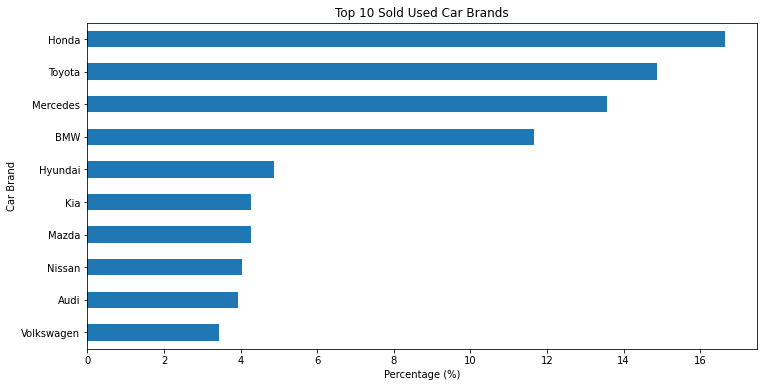

In [ ]:
import matplotlib.pyplot as plt
(sgcm_sold_df.Brand.value_counts()/sgcm_sold_df.shape[0]*100)[:10].sort_values().plot(kind='barh', figsize=(12,6))

# Title
plt.title("Top 10 Sold Used Car Brands")

# X-Label
plt.xlabel("Percentage (%)")

# Y-Label
plt.ylabel("Car Brand")

# Show Plot
plt.show()

## 1.2 SGCM Distribution of Sold Used Cars by Vehicle Type

In [ ]:
sgcm_sold_veh_types = sgcm_sold_df.loc[~sgcm_sold_df['Vehicle Type'].isin(['Van', 'Truck', 'Bus'])]
ax = sgcm_sold_veh_types['Vehicle Type'].value_counts(normalize=True).sort_values().plot(kind='barh', figsize=(12,6)) # relative frequencies (%) of the unique values
ax.set_title('Distribution of Sold Used Cars by Vehicle Type')
ax.set_xlabel('Relative Frequency')

# 2. Scraping SGCM Latest Used Car Listings

## Scraping data

In [ ]:
sgcm_latest_listings = []

listing_positions = [3, 13, 23, 33, 43, 50, 60, 70, 80, 90, 100, 116, 126, 136, 147, 157, 167, 177, 187, 197]

url_count = 0
for i in range(50):
    url = f"https://www.sgcarmart.com/used_cars/listing.php?BRSR={url_count}&RPG=20&AVL=2&CTS[]=18&CTS[]=2&ASL=1"
    res = requests.get(url)
    soup = BeautifulSoup(res.content, "html.parser")
    listings = soup.find('div', id='content').find_all('table')

    for listing_psn in listing_positions:
        curr_listing = listings[listing_psn] # 3, 13, 23, 33, 43, 50, 60, 70, 80, 90, 100, 116, 126, 136, 147, 157, 167, 177, 187, 197

        try:
            curr_listing_details = curr_listing.get_text()
            curr_listing_details = curr_listing_details.replace("\n", "")
            listing_title = curr_listing_details.split('$')[0].strip()
            price = curr_listing_details.split('$')[1].strip()
            depr = curr_listing_details.split('$')[2].split('/')[0].strip()
            reg = curr_listing_details.split('$')[2].split('/')[1].split('yr')[1].strip()[:11]
            engine_cap = curr_listing_details.split('$')[2].split('/')[1].split('yr')[1].strip().split('/')[0][143:151]
            mileage = curr_listing_details.split('$')[2].split('/')[1].split('cc')[1].split('km')[0].strip()
            veh_type = curr_listing_details.split('$')[2].split('/')[1].split('km')[1].split()[0]

            row = {
                "Listing Name": listing_title,
                "Price": price,
                "Depreciation/year": depr,
                "Registration Date": reg,
                "Engine Capacity": engine_cap,
                "Mileage (km)": mileage,
                "Vehicle Type": veh_type
            }

            sgcm_latest_listings.append(row)
        except:
            continue

    url_count+=20

In [ ]:
sgcm_latest_df = pd.DataFrame(sgcm_latest_listings)
# print(sgcm_df.to_string())
sgcm_latest_df.head()

,Listing Name,Price,Depreciation/year,Registration Date,Engine Capacity,Mileage (km),Vehicle Type
0,Mercedes-Benz A-Class Saloon A200 AMG Line,"175,800","20,680",23-Apr-2020,"1,332 cc","19,000",Luxury
1,Toyota C-HR Hybrid 1.8A S LED,"87,888","14,680",27-Apr-2018,"1,797 cc","59,000",SUV
2,BMW 3 Series 316i (New 10-yr COE),"125,000","12,490",27-Jan-2014,"1,598 cc","122,000",Luxury
3,Toyota Corolla Altis 1.6A (COE till 10/2028),"50,800","8,370",02-Oct-2008,,"158,282",Sedan
4,Toyota Sienta Hybrid 1.5A X,"106,800","13,920",17-Sep-2019,"1,496 cc","30,000",MPV


In [ ]:
sgcm_latest_df.shape

(612, 7)

In [ ]:
sgcm_latest_df['Brand'] = sgcm_latest_df['Listing Name'].apply(lambda x: x.split()[0])

## 2.1 Price Distribution of Top 10 Car Brands

In [ ]:
## Based on Top 10 car brands based on sold listings (1.1), find price distribution of these brands based on pricing info from latest listings
top_10_brands = sgcm_sold_df['Brand'].value_counts()[:10].index.tolist()
sgcm_latest_df['Price'] = sgcm_latest_df['Price'].str.replace(',', '')

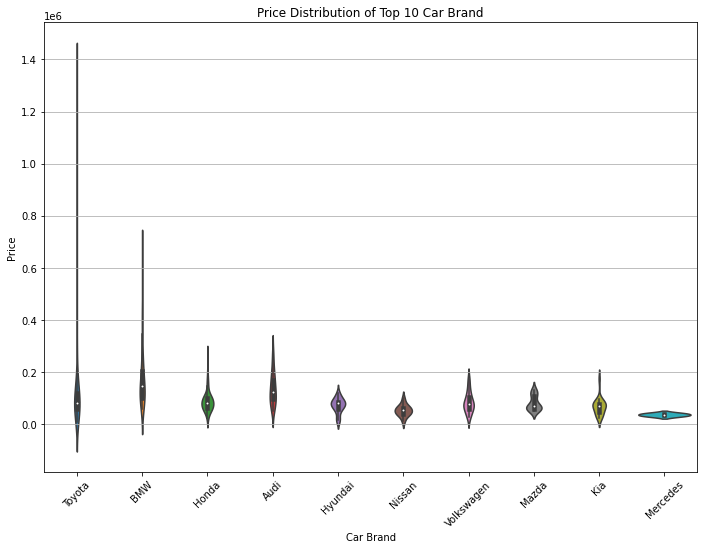

In [ ]:
fig, axes = plt.subplots()
fig.set_size_inches(11.7, 8.27)
# sgcm_latest_df['Price'] = sgcm_latest_df['Price'].str.replace(',', '')
sgcm_latest_df['Price'] = sgcm_latest_df['Price'].astype('int')
sgcm_latest_df = sgcm_latest_df.loc[sgcm_latest_df.Price > 0]
# sgcm_violin = sgcm_latest_df.loc[sgcm_latest_df['Brand'].isin(['Mercedes-Benz', 'Toyota', 'BMW', 'Honda', 'Audi', 'Porsche', 'Kia', 'Volkswagen', 'Nissan', 'Mazda'])]
sgcm_violin = sgcm_latest_df.loc[sgcm_latest_df['Brand'].isin(top_10_brands)]
sns.violinplot(x='Brand', y='Price', data=sgcm_violin, ax=axes)
axes.set_title('Price Distribution of Top 10 Car Brand')
axes.yaxis.grid(True)
axes.set_xlabel('Car Brand')
axes.set_ylabel('Price')
plt.xticks(rotation=45)
plt.show()

## Others

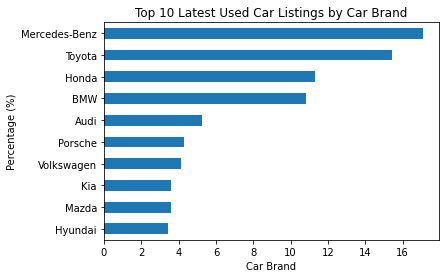

In [ ]:
import matplotlib.pyplot as plt
(sgcm_latest_df.Brand.value_counts()/sgcm_latest_df.shape[0]*100)[:10].sort_values().plot(kind='barh')

# Title
plt.title("Top 10 Latest Used Car Listings by Car Brand")

# X-Label
plt.xlabel("Car Brand")

# Y-Label
plt.ylabel("Percentage (%)")

# Show Plot
plt.show()

In [ ]:
sgcm_latest_df['Vehicle Type'].unique()

array(['Luxury', 'SUV', 'Sedan', 'MPV', 'Hatchback', 'Sports',
       'Stationwagon', 'Van', 'Truck', 'on', 'per', '!'], dtype=object)

In [ ]:
sgcm_latest_df = sgcm_latest_df.loc[sgcm_latest_df['Vehicle Type'].isin(['Sports', 'MPV', 'Hatchback', 'Truck', 'Luxury', 'Sedan', 'SUV', 'Van', 'Stationwagon'])]

In [ ]:
# check that invalid vehicle types have been dropped
sgcm_latest_df['Vehicle Type'].unique()

array(['Luxury', 'SUV', 'Sedan', 'MPV', 'Hatchback', 'Sports',
       'Stationwagon', 'Van', 'Truck'], dtype=object)

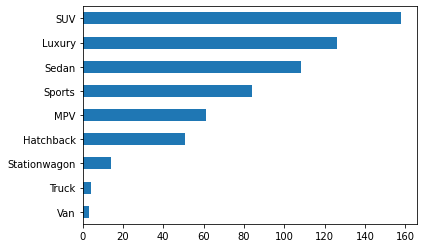

In [ ]:
sgcm_latest_df['Vehicle Type'].value_counts().sort_values().plot(kind='barh')

In [ ]:
sgcm_latest_df['Mileage (km)'] = sgcm_latest_df['Mileage (km)'].str.replace(',', '')
# sgcm_df.loc[sgcm_df['Mileage (km)'].str.contains('Luxury')]

In [ ]:
# drop rows where 'Vehicle Type' is '(fuel+CNG).', '.' or 'with' 
invalid_types = '|'.join(['by', 'Fast'])
# print(invalid_types)
rows_with_invalid_data = sgcm_latest_df[sgcm_latest_df['Vehicle Type'].str.contains(invalid_types)]
rows_to_drop_index = rows_with_invalid_data.index.tolist()
for idx in rows_to_drop_index:
  sgcm_df.drop(idx, inplace=True)

In [ ]:
sgcm_latest_df['Mileage (km)'] = sgcm_latest_df['Mileage (km)'].astype('int')

sgcm_latest_df.hist(column='Mileage (km)')

ValueError: ignored

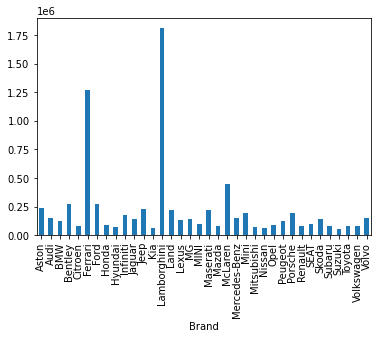

In [ ]:
sgcm_df['Price'] = sgcm_df['Price'].str.replace(',', '')
sgcm_df.groupby('Brand')['Price'].median().plot(kind='bar')

## SGCM Top 30 Used Car Dealers for past 11 years (2012-2022)

In [ ]:
top_30_dealers_url = "https://www.sgcarmart.com/ads/premium_dealers/index.php"
res = requests.get(top_30_dealers_url)
soup = BeautifulSoup(res.content, "html.parser")
dealers_lists = soup.find('div', id='car_lists_m').find_all('td')

master_top_dealers_list = []
for dealer_list in dealers_lists:
    curr_dealers = dealer_list.find_all('li')
    for dealer in curr_dealers:
        master_top_dealers_list.append(dealer.text)

top_dealers_df = pd.DataFrame(master_top_dealers_list, columns=['Dealer'])

In [ ]:
print(top_dealers_df.shape)

top_dealers_df.head()

(330, 1)


,Dealer
0,Abwin Trading Pte Ltd
1,Autocar Pte Ltd
2,Faster Auto Trading
3,Fu Yiap Motor Trading
4,Henly Enterprises Co Pte Ltd


Text(0.5, 0, "Number of years crowned as SgCarMart's Top 30 Used Car Dealers of the year")

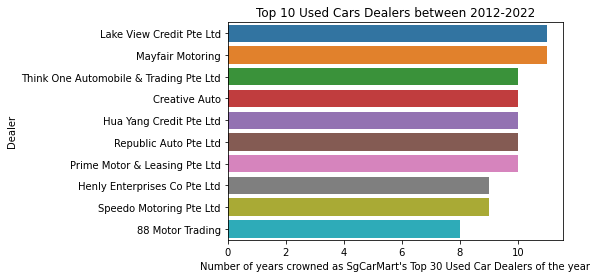

In [ ]:
# import seaborn as sns
ax = sns.countplot(y="Dealer", orient="v", order = top_dealers_df['Dealer'].value_counts().iloc[:10].index, 
                    data = top_dealers_df)
ax.set_title('Top 10 Used Cars Dealers between 2012-2022')
ax.set_xlabel('Number of years crowned as SgCarMart\'s Top 30 Used Car Dealers of the year')

## SGCM Most Viewed Used Car Listings

In [ ]:
most_popular_url = "https://www.sgcarmart.com/used_cars/most_viewed_cars.php"
res = requests.get(most_popular_url)
soup = BeautifulSoup(res.content, "html.parser")
popular_listings_table = soup.find('div', class_='newboxborder').find_all('tr')

popular_cars_list = []
href_list = []

for row in popular_listings_table:
    # for car in row:
    # print(row.find('a')['href'])
    for listing in row.find_all('a'):
        # print(r['href'])
        curr_listing = listing.text
        if curr_listing not in popular_cars_list:
            popular_cars_list.append(curr_listing)
        else:
            continue
        curr_href = listing['href']
        if curr_href not in href_list:
            href_list.append(curr_href)
        else:
            continue

In [ ]:
popular_cars_list

In [ ]:
popular_cars_list = popular_cars_list[2:] # remove invalid values

In [ ]:
popular_cars_tuples = list(zip(popular_cars_list,href_list))
popular_listings_df = pd.DataFrame(popular_cars_tuples, columns=['Listings', 'URL'])
popular_listings_df['Brand'] = popular_listings_df['Listings'].apply(lambda x: x.split()[0])

In [ ]:
popular_listings_df.head()

,Listings,URL,Brand
0,Mercedes-Benz G-Class G63 AMG 4MATIC Premium ...,info.php?ID=1129407&DL=3975,Mercedes-Benz
1,BMW 6 Series 650i Gran Coupe M-Sport Sunroof ...,info.php?ID=1129405&DL=3975,BMW
2,Alpine A110 1.8A,info.php?ID=1130188&DL=2178,Alpine
3,Mercedes-Benz C-Class C180 AMG Line,info.php?ID=1129710&DL=1213,Mercedes-Benz
4,BMW 4 Series 420i Coupe Sunroof,info.php?ID=1129724&DL=1000,BMW


In [ ]:
# scrape vehicle type for each of the most viewed car listings
for idx in range(popular_listings_df.shape[0]):
    car_href = popular_listings_df.loc[idx, "URL"]
    curr_car_url = 'https://www.sgcarmart.com/used_cars/' + car_href
    
    # scrape vehicle type 
    res = requests.get(curr_car_url)
    soup = BeautifulSoup(res.content, "html.parser")
    
    try:
        car_details = soup.find('table', id='carInfo').find_all('tr')
        veh_type = car_details[3].find('a').text
    except:
        try:
            car_details = soup.find('table', id='carInfo').find_all('tr')[2].get_text().split('\n')
            details_lst = []
            for detail in car_details:
                if detail.strip():
                    details_lst.append(detail)
            veh_type = details_lst[13].strip()
        except:
            print(idx)
            print(popular_listings_df.loc[idx, "Listings"])
            continue

    # setting vehicle type value
    popular_listings_df.loc[idx, "Vehicle Type"] = veh_type

9
Mitsubishi Pajero 2.6M (COE till 06/2031)
13
Mitsubishi Jeep J3


In [ ]:
popular_listings_df['Vehicle Type'].isnull().sum()

2

Text(0.5, 1.0, 'Distribution of Most Viewed Used Cars by Vehicle Type')

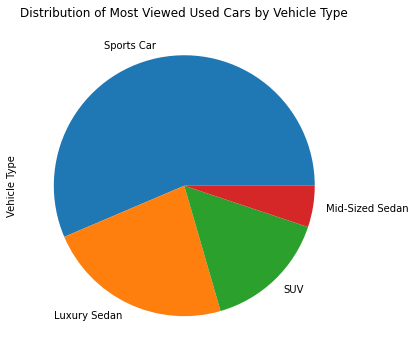

In [ ]:
ax = popular_listings_df['Vehicle Type'].value_counts().plot(kind='pie', figsize=(12,6))
ax.set_title('Distribution of Most Viewed Used Cars by Vehicle Type')

Text(0.5, 0, 'Relative Frequency')

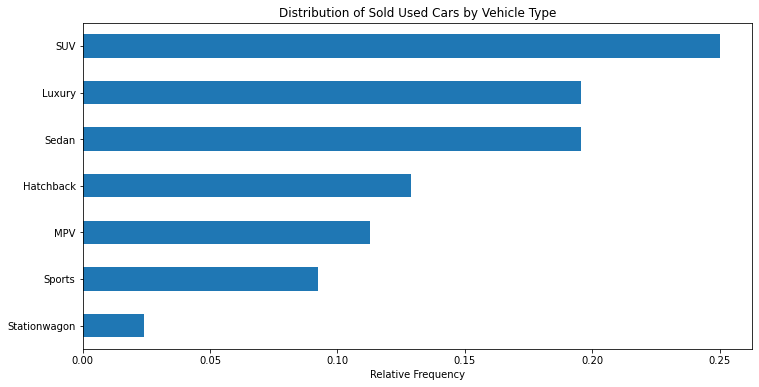

In [ ]:
# compare to distribution of SOLD USED CARS by Vehicle Type
sgcm_sold_veh_types = sgcm_sold_df.loc[~sgcm_sold_df['Vehicle Type'].isin(['Van', 'Truck', 'Bus'])]
ax = sgcm_sold_veh_types['Vehicle Type'].value_counts(normalize=True).sort_values().plot(kind='barh', figsize=(12,6)) # relative frequencies (%) of the unique values
ax.set_title('Distribution of Sold Used Cars by Vehicle Type')
ax.set_xlabel('Relative Frequency')

In [ ]:
popular_listings_df.sort_values(["Brand", "Vehicle Type"])

,Listings,URL,Brand,Vehicle Type
2,Alpine A110 1.8A,info.php?ID=1130188&DL=2178,Alpine,Sports Car
35,Aston Martin Rapide 6.0A (New 10-yr COE),info.php?ID=1131105&DL=1000,Aston,Sports Car
1,BMW 6 Series 650i Gran Coupe M-Sport Sunroof ...,info.php?ID=1129405&DL=3975,BMW,Luxury Sedan
28,BMW 3 Series 316i,info.php?ID=1130052&DL=1000,BMW,Luxury Sedan
38,BMW X6 xDrive40i M-Sport,info.php?ID=1131086&DL=1213,BMW,SUV
40,BMW M Series X4 M40i,info.php?ID=1130104&DL=1400,BMW,SUV
4,BMW 4 Series 420i Coupe Sunroof,info.php?ID=1129724&DL=1000,BMW,Sports Car
11,BMW 4 Series 420i Coupe M-Sport,info.php?ID=1130083&DL=1089,BMW,Sports Car
16,BMW M Series M2 Coupe,info.php?ID=1131096&DL=1000,BMW,Sports Car
31,BMW M Series M3 (COE till 07/2030),info.php?ID=1131089&DL=3414,BMW,Sports Car


Text(0.5, 0, 'Number of Listings')

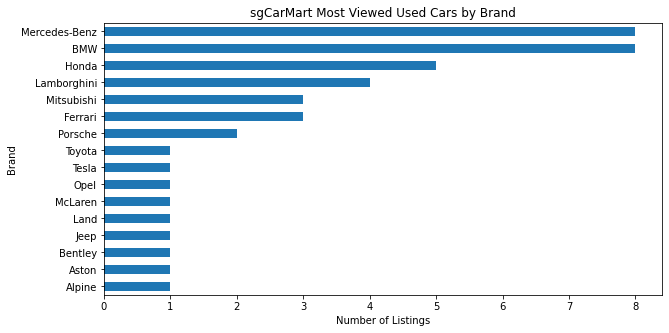

In [ ]:
ax = popular_listings_df.groupby('Brand').size().sort_values().plot.barh(figsize=(10, 5))
ax.set_title('sgCarMart Most Viewed Used Cars by Brand')
ax.set_xlabel('Number of Listings')